## Análisis de los datos históricos de Racimo y AMB

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#Another way to smooth
from scipy.ndimage import gaussian_filter1d
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import folium
import scipy as sp
from scipy import signal

In [2]:
def rolling(y,n):  #Rolling data to smooth values
    rolling = y.rolling(window = n , center = True , min_periods = 1)
    return  rolling.median()

def renamecol(data,station):
    data.rename(columns={'pm10_a': 'pm10_'+str(station), 'pm25': 'pm25_'+str(station), 
                               't': 't_'+str(station), 'p': 'p_'+str(station), 'h': 'h_'+str(station)})
    return data

def loaddata_racimo(name):
    data=pd.read_csv(name,delimiter=',')
    data=data.drop(data[data.id_parametro =='alert'].index)
    data.valor=pd.to_numeric(data.valor)
    pivot_data=pd.pivot_table(data,index='fecha_hora_med', columns='id_parametro', 
                              values='valor').reset_index().set_index("fecha_hora_med")    
    #keep really needed cols and important variables ("pm10_a","pm25_a","t","p","h")
    cols_keep=["pm10","pm10_a","pm25","pm25_a","t","p","h"]
    pivot_data=pivot_data[cols_keep]    
    pivot_data.index = pd.DatetimeIndex(pivot_data.index) - pd.Timedelta(hours = 5)
    pivot_data  = pivot_data.resample('60T').mean()
    pivot_data.index = pivot_data.index.strftime('%Y-%m-%d %H:%M:%S')
    pivot_data.index.name = None
    pivot_data.columns.name = None
    pivot_data.index = pd.to_datetime(pivot_data.index)
#    for i in pivot_data.columns:
#        pivot_data[i]=rolling(pivot_data[i],5)
    #pivot_data["pm10"]=rolling(pivot_data["pm10"],10)
    #pivot_data["pm25"]=rolling(pivot_data["pm25"],10)
    return pivot_data

In [3]:
def clean_nan(data,var):
    b = np.array(data[var])
    b = np.where(b == 'NoData',np.nan,b)
    b = np.where(b == '---',np.nan,b)
    b = np.where(b == '<Samp',np.nan,b)
    b = np.where(b == 'OffScan',np.nan,b)
    b = np.where(b == 'Zero',np.nan,b)
    b = np.where(b == 'Calib',np.nan,b)
    b = np.where(b == 'InVld',np.nan,b)
    data[var] = list(b)
    return data

def loaddata_amb(name):
    data_AMB = pd.read_excel(name, header=0)
    #data_AMB.columns = list(data_AMB.iloc[0])
    data_AMB.index = list(data_AMB["Date&Time"])
    data_AMB = data_AMB[3:-8] 
    data_AMB.index = pd.DatetimeIndex(data_AMB.index,dayfirst = True) 
    data_AMB.index = data_AMB.index.astype(str)
    data_AMB = data_AMB.drop(['Date&Time'], axis=1)
    data_AMB.index = pd.to_datetime(data_AMB.index)


    for i in data_AMB.columns:
        data_AMB=clean_nan(data_AMB,i)
    for i in data_AMB.columns:
        data_AMB[i]=pd.to_numeric(data_AMB[i])
    return data_AMB

In [4]:
def cutdata(data,start_date = '2020-12-03 00:00:00',end_date = '2020-12-08 21:00:00'):
    #start_date = '2020-12-04 00:00:00'
    #end_date = '2020-12-12 23:00:00'
    mask = (data.index >= start_date) & (data.index <= end_date)
    data=data[mask]
    return data

In [5]:
amb_acualago=loaddata_amb("MiData_Arreglada/amb_acualago.xls")
amb_caldas=loaddata_amb("MiData_Arreglada/amb_caldas.xls")
amb_giron=loaddata_amb("MiData_Arreglada/amb_giron.xls")
amb_normal=loaddata_amb("MiData_Arreglada/amb_normal.xls")
amb_pilar=loaddata_amb("MiData_Arreglada/amb_pilar.xls")

In [6]:
comuneros=loaddata_racimo("MiData_Arreglada/comuneros.csv")
ecologico=loaddata_racimo("MiData_Arreglada/ecologico.csv")
galan=loaddata_racimo("MiData_Arreglada/galan.csv")
isidrocaballero=loaddata_racimo("MiData_Arreglada/isidrocaballero.csv")
itsdz=loaddata_racimo("MiData_Arreglada/itsdz.csv")
mutis=loaddata_racimo("MiData_Arreglada/mutis.csv")
normal=loaddata_racimo("MiData_Arreglada/normal.csv")
santander=loaddata_racimo("MiData_Arreglada/santander.csv")

In [7]:
for i in [amb_acualago,amb_caldas,amb_giron,amb_normal,amb_pilar]:
    print("Datos desde",i.index.min(),"hasta",i.index.max())

Datos desde 2018-10-01 03:00:00 hasta 2019-08-31 15:00:00
Datos desde 2018-10-01 02:00:00 hasta 2019-08-31 15:00:00
Datos desde 2018-10-01 02:00:00 hasta 2019-08-31 15:00:00
Datos desde 2018-10-01 02:00:00 hasta 2019-08-31 15:00:00
Datos desde 2018-10-01 02:00:00 hasta 2019-08-31 15:00:00


In [8]:
for i, j in zip([comuneros,ecologico,galan,isidrocaballero,itsdz,mutis,normal,santander],["comuneros","ecologico","galan","isidrocaballero","itsdz","mutis","normal","santander"]):
    print("En la estación {} hay datos desde".format(j),i.index.min(),"hasta",i.index.max())

En la estación comuneros hay datos desde 2018-11-03 18:00:00 hasta 2020-11-27 15:00:00
En la estación ecologico hay datos desde 2018-12-31 19:00:00 hasta 2019-09-18 19:00:00
En la estación galan hay datos desde 2018-12-31 19:00:00 hasta 2019-09-18 19:00:00
En la estación isidrocaballero hay datos desde 2019-04-11 14:00:00 hasta 2020-04-04 06:00:00
En la estación itsdz hay datos desde 2018-12-31 19:00:00 hasta 2020-11-27 15:00:00
En la estación mutis hay datos desde 2018-12-31 19:00:00 hasta 2020-05-12 05:00:00
En la estación normal hay datos desde 2019-04-11 12:00:00 hasta 2019-09-18 19:00:00
En la estación santander hay datos desde 2018-11-03 18:00:00 hasta 2021-01-25 11:00:00


In [9]:
racimodict={"comuneros":[7.13605040,-73.1287364],"ecologico":[7.03922040,-73.1194441],"galan":[7.09200830,-73.0919307],
         "isidrocaballero":[7.08807850,-73.0994883],"itsdz":[7.13863530,-73.11866490000001],"mutis":[7.1059880,-73.1236424],
         "normal":[7.126296,-73.1195564],"santander":[7.13936450,-73.1224860999]}
ambdict={"amb_acualago":[7.071854,-73.101586],"amb_caldas":[7.099963,-73.104161],"amb_giron":[7.060667,-73.172077],
            "amb_normal":[7.1270292,-73.1182707],"amb_pilar":[7.106642,-73.123992]}

In [10]:
ambloc=pd.DataFrame(ambdict).T
racimoloc=pd.DataFrame(racimodict).T
ambnames=["amb_acualago","amb_caldas","amb_giron","amb_normal","amb_pilar"]
racimonames=["comuneros","ecologico","galan","isidrocaballero","itsdz","mutis","normal","santander"]

# Visualizando estaciones geográficamente..

In [11]:
map = folium.Map(location=[np.mean(ambloc[0]),np.mean(ambloc[1])], zoom_start=13)
for point in range(0, len(ambloc)):
    folium.Marker([ambloc[0][point],ambloc[1][point]], popup=folium.Popup(ambnames[point],show=False), icon=folium.Icon(color='blue',prefix='fa',icon='pagelines')).add_to(map)
for point in range(0, len(racimoloc)):
    folium.Marker([racimoloc[0][point],racimoloc[1][point]], popup=folium.Popup(racimonames[point],show=False), icon=folium.Icon(color='red',prefix='fa',icon='pagelines',angle='90')).add_to(map)
map

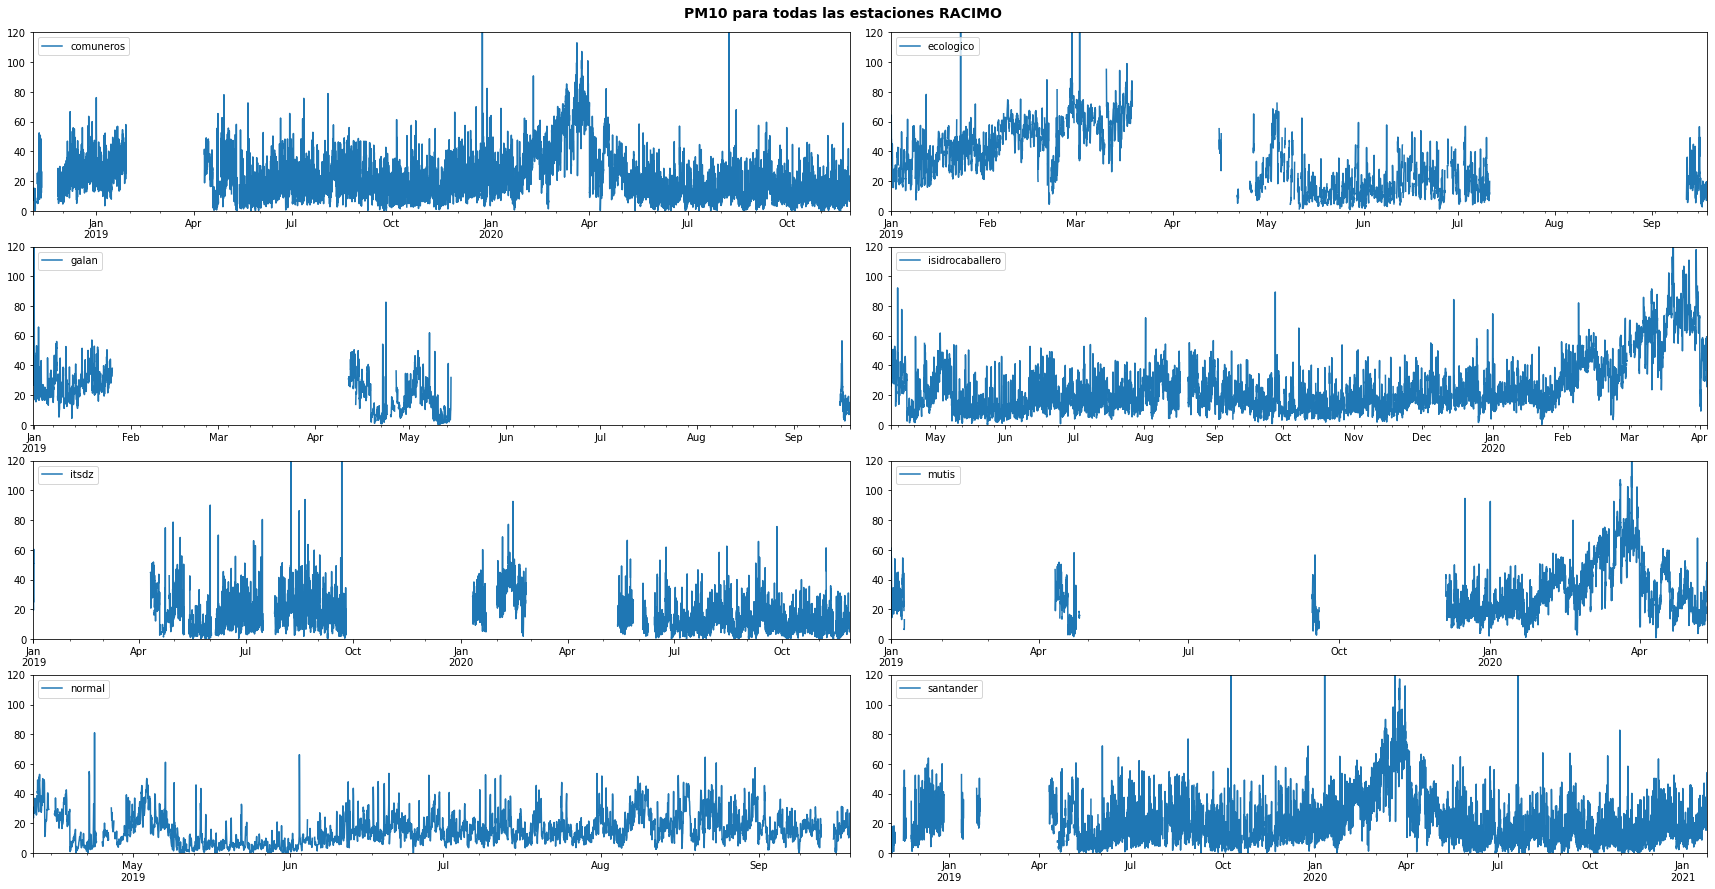

In [12]:
plt.figure(figsize=(30,12))
plt.suptitle("PM10 para todas las estaciones RACIMO",fontweight='bold',fontsize=14)
plt.subplots_adjust(left = 0.125,right = 0.9,bottom = 0.0,top = 0.95,wspace = 0.05,hspace = 0.2)
for i, j in enumerate(zip([comuneros,ecologico,galan,isidrocaballero,itsdz,mutis,normal,santander],["comuneros","ecologico","galan","isidrocaballero","itsdz","mutis","normal","santander"])):
    plt.subplot(4,2,i+1)
    j[0].pm10_a.plot(label=j[1])
    plt.legend(loc=2)
    plt.ylim(0,120)

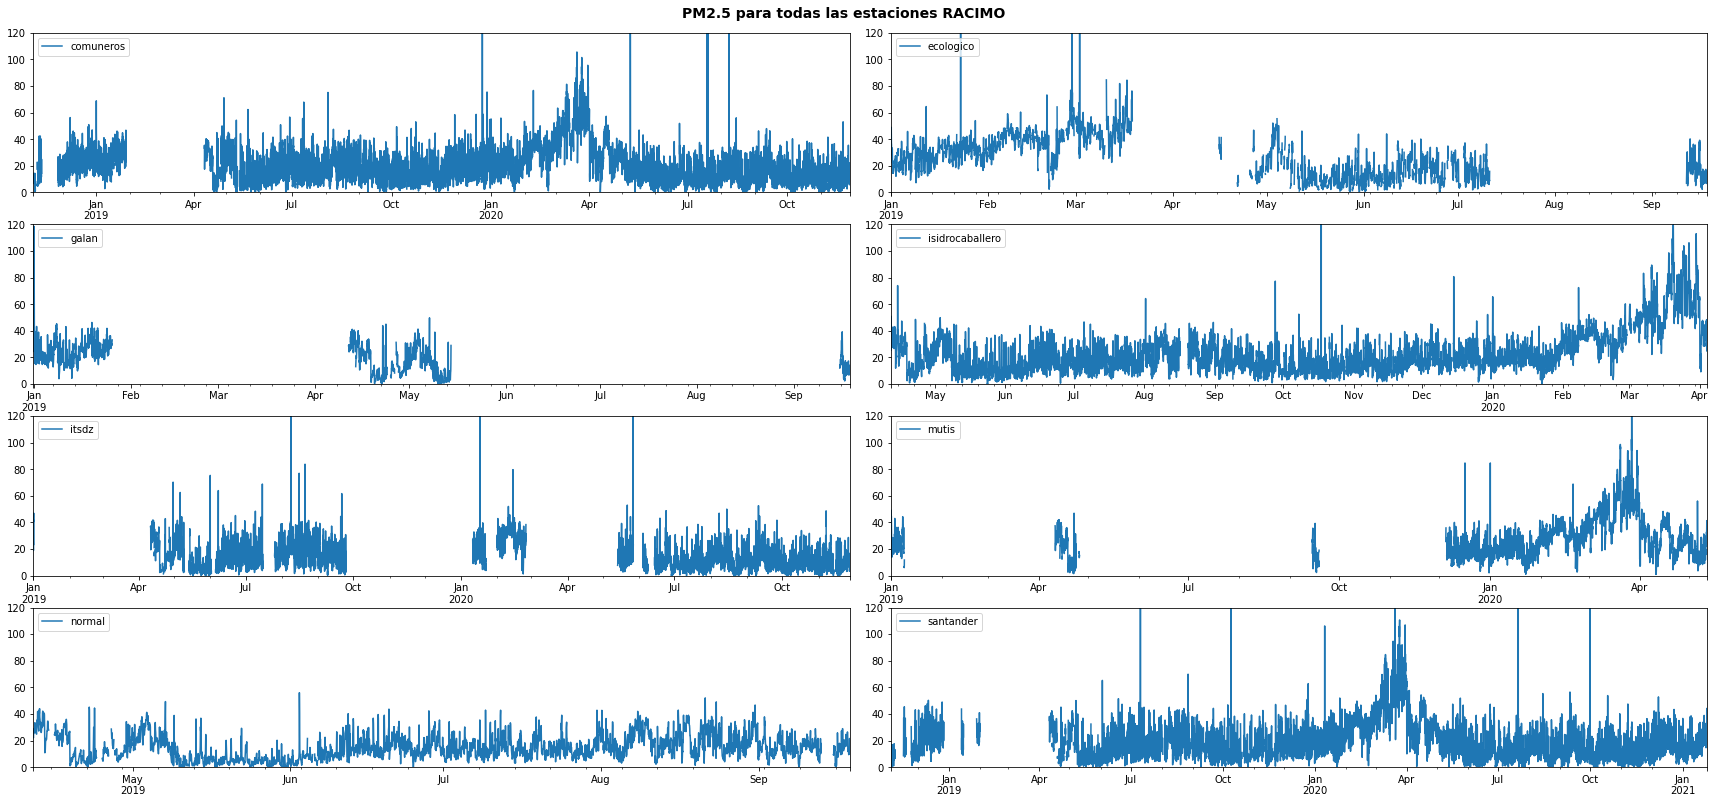

In [13]:
plt.figure(figsize=(30,12))
plt.suptitle("PM2.5 para todas las estaciones RACIMO",fontweight='bold',fontsize=14)
plt.subplots_adjust(left = 0.125,right = 0.9,bottom = 0.1,top = 0.95,wspace = 0.05,hspace = 0.2)
for i, j in enumerate(zip([comuneros,ecologico,galan,isidrocaballero,itsdz,mutis,normal,santander],["comuneros","ecologico","galan","isidrocaballero","itsdz","mutis","normal","santander"])):
    plt.subplot(4,2,i+1)
    j[0].pm25_a.plot(label=j[1])
    plt.legend(loc=2)
    plt.ylim(0,120)

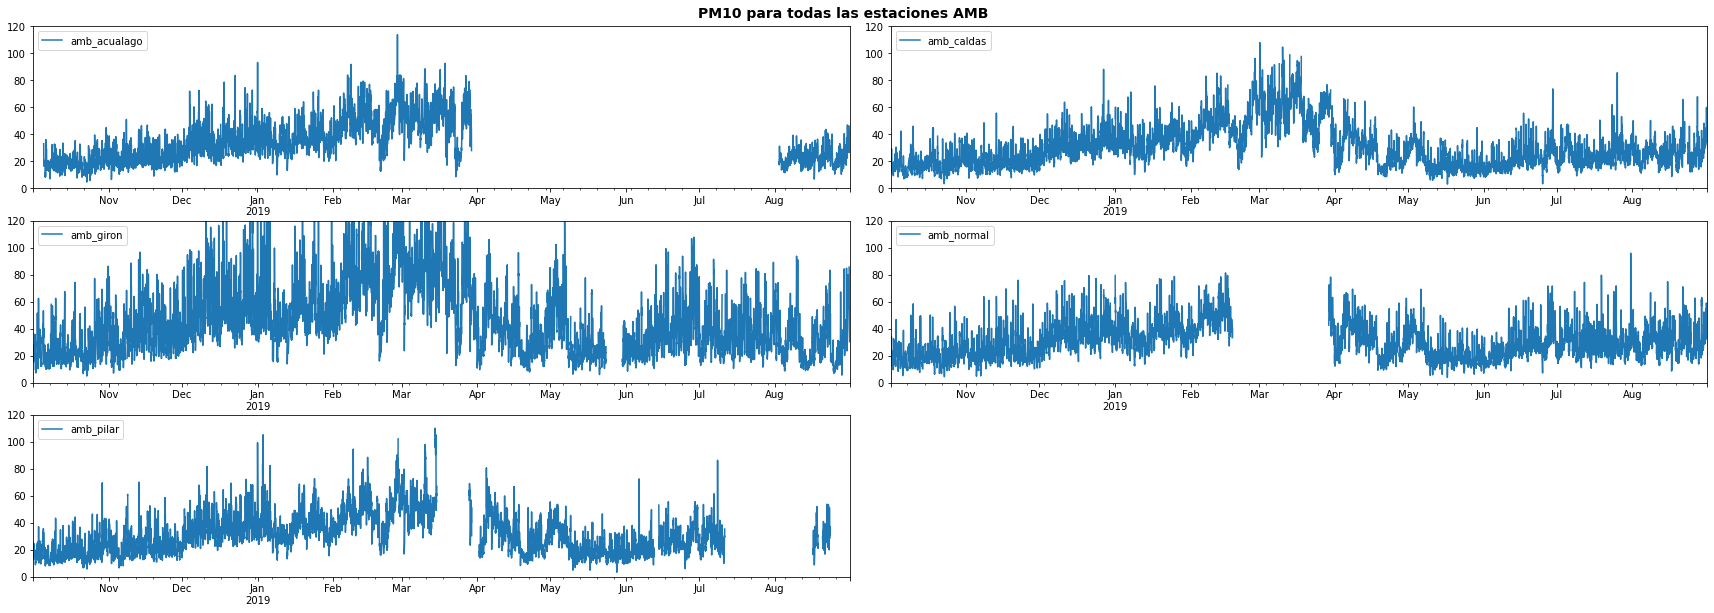

In [14]:
plt.figure(figsize=(30,9))
plt.suptitle("PM10 para todas las estaciones AMB",fontweight='bold',fontsize=14)
plt.subplots_adjust(left = 0.125,right = 0.9,bottom = 0.1,top = 0.95,wspace = 0.05,hspace = 0.2)
for i, j in enumerate(zip([amb_acualago,amb_caldas,amb_giron,amb_normal,amb_pilar],["amb_acualago","amb_caldas","amb_giron","amb_normal","amb_pilar"])):
    plt.subplot(3,2,i+1)
    j[0].PM10.plot(label=j[1])
    plt.legend(loc=2)
    plt.ylim(0,120)

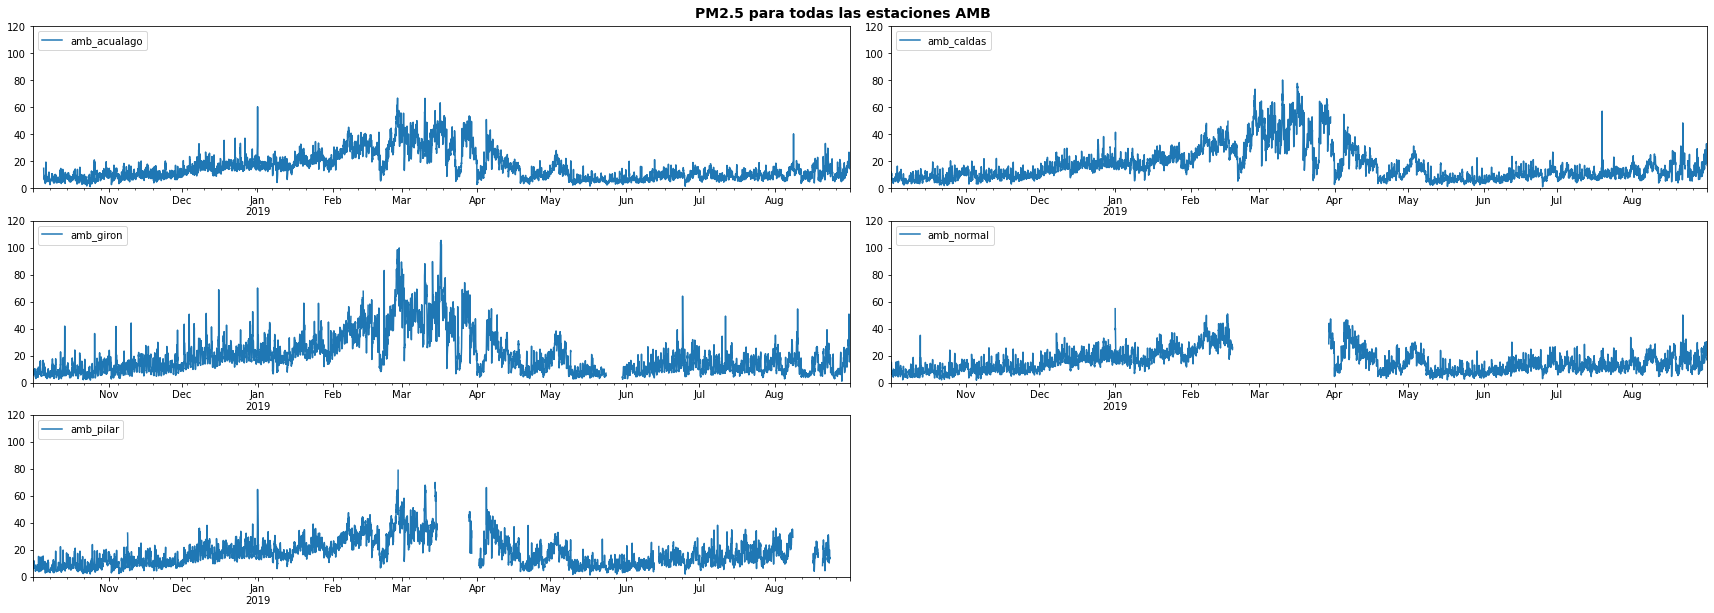

In [15]:
plt.figure(figsize=(30,9))
plt.suptitle("PM2.5 para todas las estaciones AMB",fontweight='bold',fontsize=14)
plt.subplots_adjust(left = 0.125,right = 0.9,bottom = 0.1,top = 0.95,wspace = 0.05,hspace = 0.2)
for i, j in enumerate(zip([amb_acualago,amb_caldas,amb_giron,amb_normal,amb_pilar],["amb_acualago","amb_caldas","amb_giron","amb_normal","amb_pilar"])):
    plt.subplot(3,2,i+1)
    j[0]["PM2.5"].plot(label=j[1])
    plt.legend(loc=2)
    plt.ylim(0,120)

In [16]:
all_mutis = pd.concat([amb_pilar, mutis], axis=1)
all_normal = pd.concat([amb_normal, normal], axis=1)

In [17]:
for i in all_mutis.columns:
    #print(i)
    all_mutis[i]=sp.signal.medfilt(all_mutis[i],21)
for i in all_normal.columns:
    #print(i)
    all_normal[i]=sp.signal.medfilt(all_normal[i],21)

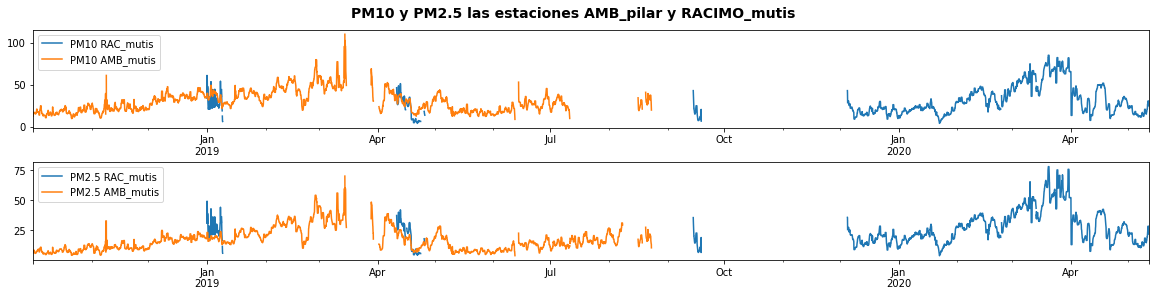

In [18]:
plt.figure(figsize=(20,4))
plt.suptitle("PM10 y PM2.5 las estaciones AMB_pilar y RACIMO_mutis",fontweight='bold',fontsize=14)
plt.subplots_adjust(left = 0.125,right = 0.9,bottom = 0.1,top = 0.9,wspace = 0.05,hspace = 0.35)
plt.subplot(2,1,1)
all_mutis.pm10_a.plot(label='PM10 RAC_mutis')
all_mutis.PM10.plot(label='PM10 AMB_mutis')
plt.legend()
plt.subplot(2,1,2)
all_mutis.pm25_a.plot(label='PM2.5 RAC_mutis')
all_mutis["PM2.5"].plot(label='PM2.5 AMB_mutis')
plt.legend()
plt.show()

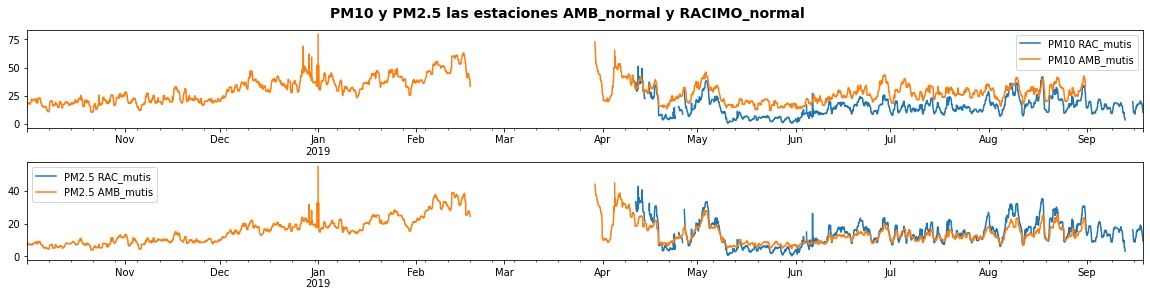

In [19]:
plt.figure(figsize=(20,4))
plt.suptitle("PM10 y PM2.5 las estaciones AMB_normal y RACIMO_normal",fontweight='bold',fontsize=14)
plt.subplots_adjust(left = 0.125,right = 0.9,bottom = 0.1,top = 0.9,wspace = 0.05,hspace = 0.35)
plt.subplot(2,1,1)
all_normal.pm10_a.plot(label='PM10 RAC_mutis')
all_normal.PM10.plot(label='PM10 AMB_mutis')
plt.legend()
plt.subplot(2,1,2)
all_normal.pm25_a.plot(label='PM2.5 RAC_mutis')
all_normal["PM2.5"].plot(label='PM2.5 AMB_mutis')
plt.legend()
plt.show()

In [20]:
all_mutis_new=all_mutis.dropna()
all_normal_new=all_normal.dropna()

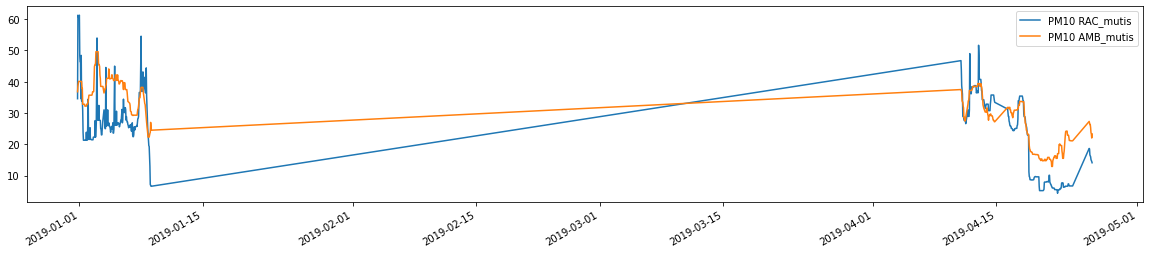

In [21]:
plt.figure(figsize=(20,4))
all_mutis_new.pm10_a.plot(label='PM10 RAC_mutis')
all_mutis_new.PM10.plot(label='PM10 AMB_mutis')
plt.legend()
plt.show()

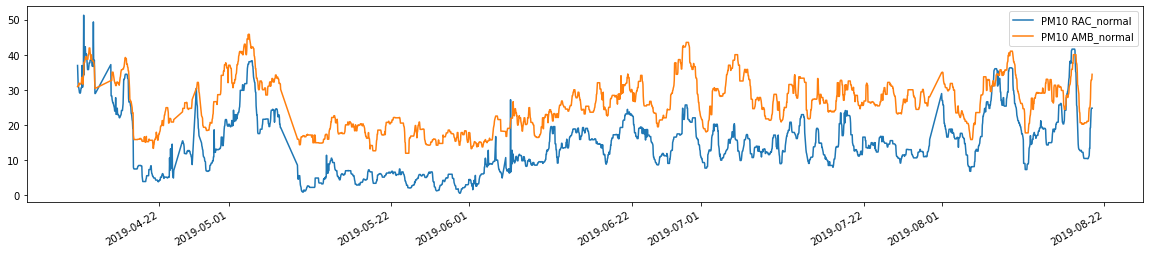

In [22]:
plt.figure(figsize=(20,4))
all_normal_new.pm10_a.plot(label='PM10 RAC_normal')
all_normal_new.PM10.plot(label='PM10 AMB_normal')
plt.legend()
plt.show()

# Distancias aproximadas entre estaciones (distancias en kilómetros)...!

| | amb_acualago | amb_caldas | amb_giron | amb_normal | amb_pilar |
| :--- | :----: | :---: | :----: | :---: | :----: |
| **itsdz** | 7.62 | 4.63 | 10.38 | 1.33 | 3.68 |
| **comuneros** | 7.72 | 4.86 | 9.55 | 1.55 | 3.33 |
| **normal** | 6.38 | 3.38 | 9.25 | **0.16** | 2.26 |
| **mutis** | 4.55 | 2.26 | 7.40 | 2.37 | **0.08** |
| **ecologico** | 4.12 | 6.93 | 6.26 | 9.77 | 7.59 |
| **isidrocaballero** | 1.83 | 1.40 | 8.59 | 4.75 | 3.42 |
| **galan** | 2.54 | 1.63 | 9.49 | 4.81 | 3.88 |
| **santander** | 7.88 | 4.86 | 10.26 | 1.51 | 3.64 |

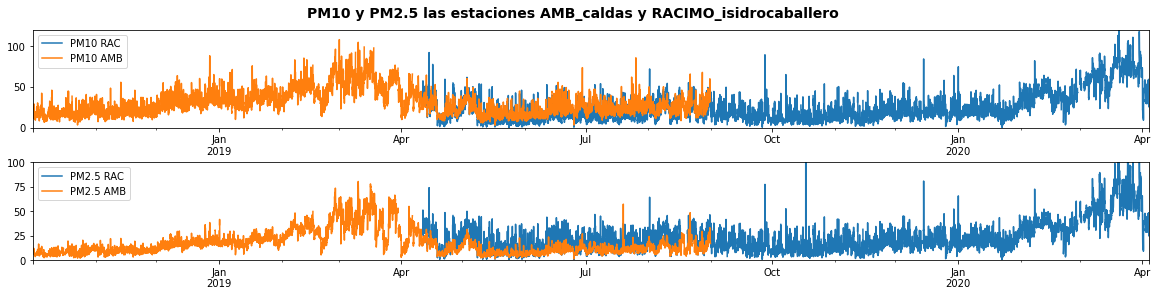

In [23]:
plt.figure(figsize=(20,4))
plt.suptitle("PM10 y PM2.5 las estaciones AMB_caldas y RACIMO_isidrocaballero",fontweight='bold',fontsize=14)
plt.subplots_adjust(left = 0.125,right = 0.9,bottom = 0.1,top = 0.9,wspace = 0.05,hspace = 0.35)
plt.subplot(2,1,1)
isidrocaballero.pm10_a.plot(label='PM10 RAC')
amb_caldas.PM10.plot(label='PM10 AMB')
plt.legend()
plt.ylim(0,120)
plt.subplot(2,1,2)
isidrocaballero.pm25_a.plot(label='PM2.5 RAC')
amb_caldas["PM2.5"].plot(label='PM2.5 AMB')
plt.legend()
plt.ylim(0,100)
plt.show()

# Un pequeño algoritmo para la calibración de las estaciones de bajo costo...

## Trying fit a simple model for data calibration

In [24]:
X = pd.DataFrame(all_normal_new["pm10_a"])
Y = all_normal_new["PM10"]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.5, random_state=9)
lin_reg_mod = LinearRegression()
lin_reg_mod.fit(X_train, y_train)
pred = lin_reg_mod.predict(X_test)
test_set_rmse = (np.sqrt(mean_squared_error(y_test, pred)))

In [25]:
print('RMSE =', test_set_rmse)
print("COEF =", lin_reg_mod.coef_)
print("Intercept =", lin_reg_mod.intercept_)

RMSE = 3.706031609118986
COEF = [0.71405938]
Intercept = 15.623202354611921


No handles with labels found to put in legend.


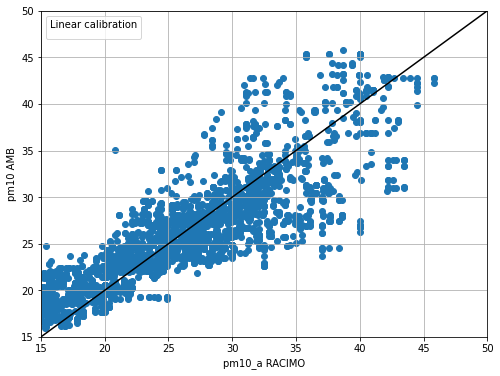

In [26]:
plt.figure(figsize=(8,6))
plt.scatter(all_normal_new["PM10"],all_normal_new["pm10_a"]*lin_reg_mod.coef_[0]+lin_reg_mod.intercept_)
x=np.linspace(15,100,10)
plt.plot(x,x,'k-')
plt.ylim(15,50)
plt.xlim(15,50)
plt.xlabel("pm10_a RACIMO")
plt.ylabel("pm10 AMB")
plt.grid()
plt.legend(title="Linear calibration")
plt.show()

## Trying fit a multiple model for data calibration

In [27]:
X = pd.DataFrame(np.c_[all_normal_new["pm10_a"], all_normal_new["t"], all_normal_new["p"], all_normal_new["h"]],columns=["pm10_a","t","p","h"])
Y = all_normal_new["PM10"]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.5, random_state=9)
lin_reg_mod2 = LinearRegression()
lin_reg_mod2.fit(X_train, y_train)
pred2 = lin_reg_mod2.predict(X_test)
test_set_rmse2 = (np.sqrt(mean_squared_error(y_test, pred2)))

In [28]:
print('RMSE =', test_set_rmse2)
print("COEF =", lin_reg_mod2.coef_)
print("Intercept =", lin_reg_mod2.intercept_)

RMSE = 3.197336530079972
COEF = [ 0.7556959  -0.71059894 -0.38893099 -0.58419811]
Intercept = 417.63026820861444


No handles with labels found to put in legend.


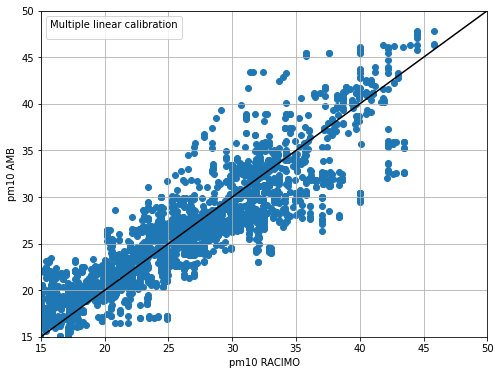

In [29]:
plt.figure(figsize=(8,6))
#comuneros["pm10"].plot(label="comuneros")
plt.scatter(all_normal_new["PM10"],all_normal_new["pm10_a"]*lin_reg_mod2.coef_[0]+
            all_normal_new["t"]*lin_reg_mod2.coef_[1]+
            all_normal_new["p"]*lin_reg_mod2.coef_[2]+
            all_normal_new["h"]*lin_reg_mod2.coef_[3]+
            lin_reg_mod2.intercept_)
#plt.scatter(all_normal_new["pm10"],all_normal_new["pm10"])
x=np.linspace(15,100,10)
plt.plot(x,x,'k-')
plt.ylim(15,50)
plt.xlim(15,50)
plt.xlabel("pm10 RACIMO")
plt.ylabel("pm10 AMB")
plt.grid()
plt.legend(title="Multiple linear calibration")
plt.show()

## Desarrollando random forest para el conjunto de datos usando SKLearn (machine Learning)...

In [30]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
#from sklearn.externals import joblib 
from sklearn.preprocessing import LabelEncoder 
from numpy.core.umath_tests import inner1d

<ipython-input-30-7f523acdadb5>:9: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [31]:
rs=np.random.randint(700)
print("seed for random_state",rs)
train_features,test_features,train_labels,test_labels=train_test_split(X,Y,test_size=0.5,random_state=rs)
# Instantiate model with 1000 decision trees
rf=RandomForestRegressor(n_estimators=800,random_state=rs)#,max_features="sqrt",criterion="mse"
# Train the model on training data
rf.fit(train_features,train_labels);
# Use the forest's predict method on the test data
predictions=rf.predict(test_features)

#=====================================================================
import joblib
# save the model to disk
filename = 'RF_model_normal.sav'
joblib.dump(rf, filename)
# some time later...
#=====================================================================
# load the model from disk
#loaded_model = joblib.load(filename)
#result = loaded_model.score(X_test, Y_test)
#=====================================================================

# Calculate the absolute errors
errors=abs(predictions-test_labels)
# Calculate mean absolute percentage error (MAPE)
mape=100*abs(errors/test_labels)
rmse=np.sqrt(np.mean(errors**2))
# Calculate and display accuracy
accuracy=100-np.mean(mape)
# Print out the mean absolute error (mae)
print('RMSE:', rmse)
print('Accuracy:', accuracy)
print('Mean Absolute Error:', np.mean(errors))

seed for random_state 294
RMSE: 1.6253398076412864
Accuracy: 95.44703501685741
Mean Absolute Error: 1.1203099777056014


No handles with labels found to put in legend.


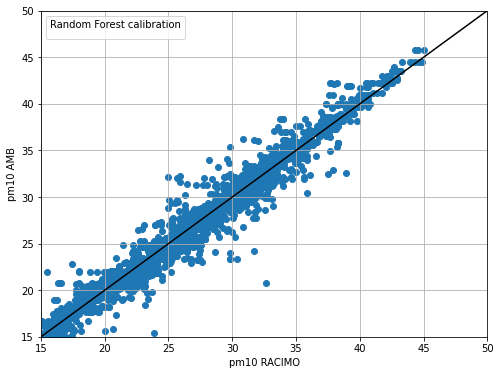

In [32]:
plt.figure(figsize=(8,6))
#axe=np.linspace(data[station].min()-0.2,data[station].max()+0.2,10)
plt.scatter(rf.predict(X),all_normal_new["PM10"],label='',lw=1,marker='o') 
x=np.linspace(15,100,10)
plt.plot(x,x,'k-')
plt.ylabel("pm10 AMB")
plt.xlabel("pm10 RACIMO")
plt.ylim(15,50)
plt.xlim(15,50)
plt.grid()
plt.legend(title="Random Forest calibration")
plt.show()

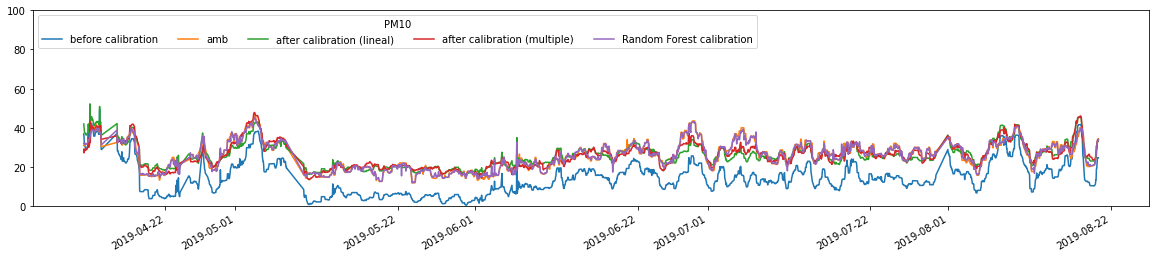

In [33]:
plt.figure(figsize=(20,4))
all_normal_new["pm10_a"].plot(label="before calibration")
all_normal_new["PM10"].plot(label="amb")
plt.plot(all_normal_new.index,all_normal_new["pm10_a"]*lin_reg_mod.coef_[0]+lin_reg_mod.intercept_,label='after calibration (lineal)')
plt.plot(all_normal_new.index,all_normal_new["pm10_a"]*lin_reg_mod2.coef_[0]+
            all_normal_new["t"]*lin_reg_mod2.coef_[1]+
            all_normal_new["p"]*lin_reg_mod2.coef_[2]+
            all_normal_new["h"]*lin_reg_mod2.coef_[3]+
            lin_reg_mod2.intercept_,label='after calibration (multiple)')
plt.plot(all_normal_new.index,rf.predict(X),label='Random Forest calibration')
plt.ylim(0,100)
plt.legend(title="PM10",loc=2,ncol=5)
plt.show()

Entonces, como conclusión y tomando en cuenta un estimador de error cuadrático medio ppodemos decir que el modelo de calibración usando random forest es efectivamente no sólo mucho mejor sino que puede reducir los errores en un buen porcentaje..

In [34]:
# En resumen:
print("Error mediante calibración lineal (RMSE):",round(test_set_rmse,2), "Relativo a calibración lineal=", round(test_set_rmse/test_set_rmse*100),"(%)")
print("Error mediante calibración lineal múltiple (RMSE):",round(test_set_rmse2,2), "Relativo a calibración lineal=", round(test_set_rmse/test_set_rmse2*100),"(%)")
print("Error mediante calibración usando Random Forest (RMSE):",round(rmse,2), "Relativo a calibración lineal=", round(test_set_rmse/rmse*100),"(%)")

Error mediante calibración lineal (RMSE): 3.71 Relativo a calibración lineal= 100 (%)
Error mediante calibración lineal múltiple (RMSE): 3.2 Relativo a calibración lineal= 116 (%)
Error mediante calibración usando Random Forest (RMSE): 1.63 Relativo a calibración lineal= 228 (%)


# Paso siguiente...
Ok, ahora vamos a evaluar el desempeño de la calibración en diferentes intervalos de tiempo para establecer escenarios de validación adecuada de los modelos..

In [35]:
print("Fecha menor en estaciones Normal",all_normal_new.index.min())
print("Fecha mayor en estaciones Normal",all_normal_new.index.max())
print("Intervalo de tiempo total",all_normal_new.index.max()-all_normal_new.index.min())

Fecha menor en estaciones Normal 2019-04-11 12:00:00
Fecha mayor en estaciones Normal 2019-08-20 10:00:00
Intervalo de tiempo total 130 days 22:00:00


Entonces para 130 días de datos (poco más de 4 meses) podemos dividir la data en cuatro partes. Hacer el modelo sobre la primera parte y evaluar el desempeño en los siguientes tres intervalos de tiempos en términos de errores.

In [36]:
def lineal_cal(data,xvar,yvar,dates=30):
    X = pd.DataFrame(data[data.index.min():data.index.min()+pd.Timedelta(days = dates)][xvar])
    Y = data[data.index.min():data.index.min()+pd.Timedelta(days = dates)][yvar]
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.9, random_state=9)
    lin_reg_mod = LinearRegression()
    lin_reg_mod.fit(X_train, y_train)
    pred = lin_reg_mod.predict(X)
    test_set_rmse = (np.sqrt(mean_squared_error(Y, pred)))
    print("Resultados de calibración para sensor",xvar,"y",yvar,"Tomando intervalos de",dates,"dias...")
    print('RMSE =', test_set_rmse)
    print("COEF =", lin_reg_mod.coef_)
    print("Intercept =", lin_reg_mod.intercept_)
    #Ahora para los intervalos
    lendata,e=[],[]
    for i in range(0,140,dates):
        inicio=data.index.min()
        x=data[inicio+pd.Timedelta(days = i):inicio+pd.Timedelta(days = i+dates)][xvar]
        y=data[inicio+pd.Timedelta(days = i):inicio+pd.Timedelta(days = i+dates)][yvar]
        y_new=lin_reg_mod.coef_*x+lin_reg_mod.intercept_
        error=np.sqrt(np.mean((y-y_new)**2))
        print(i,"Intervalo entre",inicio+pd.Timedelta(days = i),"y",inicio+pd.Timedelta(days = i+dates),"Hay",len(x),"datos","con un RMSE de",error)
        lendata.append(len(x))
        e.append(error)
        #s2,lendata,e=np.array(s2),np.array(lendata),np.array(e)
    return #lendata,e

In [37]:
lineal_cal(all_normal_new,"pm10_a","PM10",30)

Resultados de calibración para sensor pm10_a y PM10 Tomando intervalos de 30 dias...
RMSE = 3.75034698812316
COEF = [0.73619632]
Intercept = 14.868399509210732
0 Intervalo entre 2019-04-11 12:00:00 y 2019-05-11 12:00:00 Hay 570 datos con un RMSE de 3.75034698812316
30 Intervalo entre 2019-05-11 12:00:00 y 2019-06-10 12:00:00 Hay 701 datos con un RMSE de 2.717708776314787
60 Intervalo entre 2019-06-10 12:00:00 y 2019-07-10 12:00:00 Hay 721 datos con un RMSE de 4.972518005222906
90 Intervalo entre 2019-07-10 12:00:00 y 2019-08-09 12:00:00 Hay 685 datos con un RMSE de 3.2958180704339584
120 Intervalo entre 2019-08-09 12:00:00 y 2019-09-08 12:00:00 Hay 263 datos con un RMSE de 3.9641478873761025


In [38]:
lineal_cal(all_normal_new,"pm25_a","PM2.5",30)

Resultados de calibración para sensor pm25_a y PM2.5 Tomando intervalos de 30 dias...
RMSE = 1.819610160552433
COEF = [0.62689689]
Intercept = 4.6831796334113385
0 Intervalo entre 2019-04-11 12:00:00 y 2019-05-11 12:00:00 Hay 570 datos con un RMSE de 1.819610160552433
30 Intervalo entre 2019-05-11 12:00:00 y 2019-06-10 12:00:00 Hay 701 datos con un RMSE de 1.218724529121844
60 Intervalo entre 2019-06-10 12:00:00 y 2019-07-10 12:00:00 Hay 721 datos con un RMSE de 1.866104198358259
90 Intervalo entre 2019-07-10 12:00:00 y 2019-08-09 12:00:00 Hay 685 datos con un RMSE de 1.742122423267641
120 Intervalo entre 2019-08-09 12:00:00 y 2019-09-08 12:00:00 Hay 263 datos con un RMSE de 2.7990229347532574


In [39]:
def multilineal_cal(data,xvar,yvar,dates=30):
    X = data[[xvar,"t","p","h"]][data.index.min():data.index.min()+pd.Timedelta(days = dates)]
#    X0=X[X.index.min():X.index.min()+pd.Timedelta(days = dates)]
    Y = data[data.index.min():data.index.min()+pd.Timedelta(days = dates)][yvar]
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.9, random_state=9)
    lin_reg_mod2 = LinearRegression()
    lin_reg_mod2.fit(X_train, y_train)
    pred = lin_reg_mod2.predict(X_test)
    test_set_rmse = (np.sqrt(mean_squared_error(y_test, pred)))
    print('RMSE =', test_set_rmse)
    print("COEF =", lin_reg_mod2.coef_)
    print("Intercept =", lin_reg_mod2.intercept_)
    #Ahora para los intervalos
    lendata,e=[],[]
    for i in range(0,140,dates):
        inicio=data.index.min()
        x = data[[xvar,"t","p","h"]][inicio+pd.Timedelta(days = i):inicio+pd.Timedelta(days = i+dates)]
        #x0=x[x.index.min():x.index.min()+pd.Timedelta(days = dates)]
        y=data[inicio+pd.Timedelta(days = i):inicio+pd.Timedelta(days = i+dates)][yvar]
        y_new=x[xvar]*lin_reg_mod2.coef_[0]+x["t"]*lin_reg_mod2.coef_[1]+x["p"]*lin_reg_mod2.coef_[2]+x["h"]*lin_reg_mod2.coef_[3]+lin_reg_mod2.intercept_
        error=np.sqrt(np.mean((y-y_new)**2))
        print(i,"Intervalo entre",inicio+pd.Timedelta(days = i),"y",inicio+pd.Timedelta(days = i+dates),"Hay",len(x),"datos","con un RMSE de",error)
        lendata.append(len(x))
        e.append(error)
        #s2,lendata,e=np.array(s2),np.array(lendata),np.array(e)
    return #lendata,e

In [40]:
multilineal_cal(all_normal_new,"pm10_a","PM10",30)

RMSE = 2.951529517374464
COEF = [ 0.74087158 -0.41744007  0.80659945 -0.53408647]
Intercept = -670.6674769796533
0 Intervalo entre 2019-04-11 12:00:00 y 2019-05-11 12:00:00 Hay 570 datos con un RMSE de 2.9542401449878763
30 Intervalo entre 2019-05-11 12:00:00 y 2019-06-10 12:00:00 Hay 701 datos con un RMSE de 3.456455352740817
60 Intervalo entre 2019-06-10 12:00:00 y 2019-07-10 12:00:00 Hay 721 datos con un RMSE de 3.81089742852093
90 Intervalo entre 2019-07-10 12:00:00 y 2019-08-09 12:00:00 Hay 685 datos con un RMSE de 3.3557227364652955
120 Intervalo entre 2019-08-09 12:00:00 y 2019-09-08 12:00:00 Hay 263 datos con un RMSE de 5.378929999162071


In [41]:
multilineal_cal(all_normal_new,"pm25_a","PM2.5",30)

RMSE = 1.2535871648901802
COEF = [ 0.62982095 -0.50348273  0.15958146 -0.32626616]
Intercept = -106.2810696716144
0 Intervalo entre 2019-04-11 12:00:00 y 2019-05-11 12:00:00 Hay 570 datos con un RMSE de 1.251038312516042
30 Intervalo entre 2019-05-11 12:00:00 y 2019-06-10 12:00:00 Hay 701 datos con un RMSE de 1.4299165372441385
60 Intervalo entre 2019-06-10 12:00:00 y 2019-07-10 12:00:00 Hay 721 datos con un RMSE de 2.255930847926736
90 Intervalo entre 2019-07-10 12:00:00 y 2019-08-09 12:00:00 Hay 685 datos con un RMSE de 2.5109594246177718
120 Intervalo entre 2019-08-09 12:00:00 y 2019-09-08 12:00:00 Hay 263 datos con un RMSE de 3.4779964121160822


Como conclusión podemos observar que el modelo es soportable luego de 5 meses desde la primera calibración y sigue siendo óptimo sin perder su capacidad de predicción.

# Otro paso
Ahora nos preguntamos si las condiciones de calibración para una estación pudieran predecir el comportamiento de una estación vecina a una cierta distancia.
En este caso analizamos el caso de dos estaciones separadas por una distancia de 1.33 km aproximadamente.

In [42]:
def lineal_cal_def(data,xvar,yvar,name='pm10_a_normal'):
    X = pd.DataFrame(data[xvar])
    Y = data[yvar]
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.9, random_state=9)
    lin_reg_mod = LinearRegression()
    lin_reg_mod.fit(X_train, y_train)
    pred = lin_reg_mod.predict(X)
    test_set_rmse = (np.sqrt(mean_squared_error(Y, pred)))
    print("Resultados de calibración para sensor",xvar,"y",yvar)
    print('RMSE =', test_set_rmse)
    print("COEF =", lin_reg_mod.coef_)
    print("Intercept =", lin_reg_mod.intercept_)
    return pd.DataFrame(np.array([pred]).T,index=Y.index,columns=[name])

In [43]:
all_normal_normal = pd.concat([amb_normal, normal], axis=1)
all_normal_comuneros = pd.concat([amb_normal, comuneros], axis=1)
all_normal_itsdz = pd.concat([amb_normal, itsdz], axis=1)
all_normal_santander = pd.concat([amb_normal, santander], axis=1)

In [44]:
for i in all_normal_normal.columns:
    all_normal_normal[i]=sp.signal.medfilt(all_normal_normal[i],21)
for i in all_normal_comuneros.columns:
    all_normal_comuneros[i]=sp.signal.medfilt(all_normal_comuneros[i],21)
for i in all_normal_itsdz.columns:
    all_normal_itsdz[i]=sp.signal.medfilt(all_normal_itsdz[i],21)
for i in all_normal_santander.columns:
    all_normal_santander[i]=sp.signal.medfilt(all_normal_santander[i],21)

In [45]:
all_normal_normal_new=all_normal_normal.dropna()
all_normal_itsdz_new=all_normal_itsdz.dropna()
all_normal_comuneros_new=all_normal_comuneros.dropna()
all_normal_santander_new=all_normal_santander.dropna()

In [46]:
len(all_normal_normal_new), len(all_normal_comuneros_new), len(all_normal_itsdz_new), len(all_normal_santander_new)

(2936, 0, 2205, 0)

In [47]:
all_normal_normal_new2=cutdata(all_normal_normal_new,start_date = all_normal_normal_new.index.min(),end_date = all_normal_normal_new.index.max())
all_normal_itsdz_new2=cutdata(all_normal_itsdz_new,start_date = all_normal_normal_new.index.min(),end_date = all_normal_normal_new.index.max())

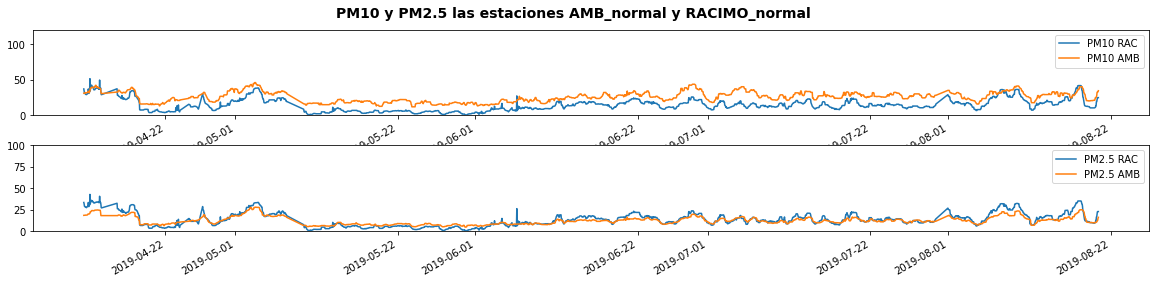

In [48]:
plt.figure(figsize=(20,4))
plt.suptitle("PM10 y PM2.5 las estaciones AMB_normal y RACIMO_normal",fontweight='bold',fontsize=14)
plt.subplots_adjust(left = 0.125,right = 0.9,bottom = 0.1,top = 0.9,wspace = 0.05,hspace = 0.35)
plt.subplot(2,1,1)
all_normal_normal_new2.pm10_a.plot(label='PM10 RAC')
all_normal_normal_new2.PM10.plot(label='PM10 AMB')
plt.legend()
plt.ylim(0,120)
plt.subplot(2,1,2)
all_normal_normal_new2.pm25_a.plot(label='PM2.5 RAC')
all_normal_normal_new2["PM2.5"].plot(label='PM2.5 AMB')
plt.legend()
plt.ylim(0,100)
plt.show()

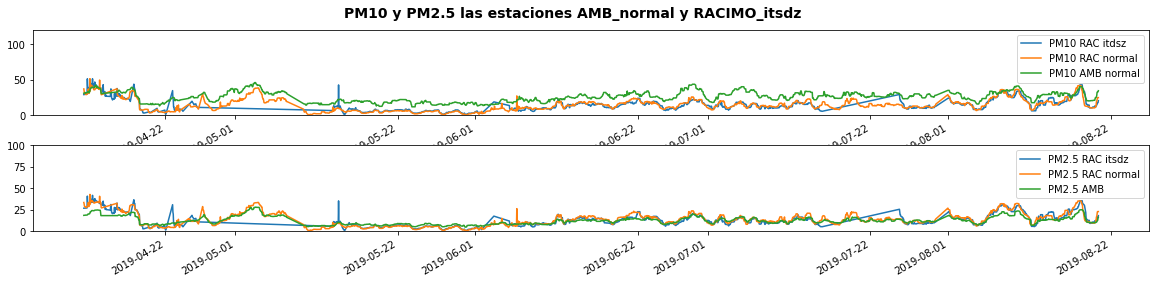

In [49]:
plt.figure(figsize=(20,4))
plt.suptitle("PM10 y PM2.5 las estaciones AMB_normal y RACIMO_itsdz",fontweight='bold',fontsize=14)
plt.subplots_adjust(left = 0.125,right = 0.9,bottom = 0.1,top = 0.9,wspace = 0.05,hspace = 0.35)
plt.subplot(2,1,1)
all_normal_itsdz_new2.pm10_a.plot(label='PM10 RAC itdsz')
all_normal_normal_new2.pm10_a.plot(label='PM10 RAC normal')
all_normal_normal_new2.PM10.plot(label='PM10 AMB normal')
plt.legend()
plt.ylim(0,120)
plt.subplot(2,1,2)
all_normal_itsdz_new2.pm25_a.plot(label='PM2.5 RAC itsdz')
all_normal_normal_new2.pm25_a.plot(label='PM2.5 RAC normal')
all_normal_normal_new2["PM2.5"].plot(label='PM2.5 AMB')
plt.legend()
plt.ylim(0,100)
plt.show()

In [50]:
pred_normal_normal=lineal_cal_def(all_normal_normal_new2,"pm10_a","PM10","pm10_a_normal")

Resultados de calibración para sensor pm10_a y PM10
RMSE = 3.793218109056197
COEF = [0.71148913]
Intercept = 15.67352548208174


In [51]:
pred_normal_itsdz=lineal_cal_def(all_normal_itsdz_new2,"pm10_a","PM10","pm10_a_itsdz")

Resultados de calibración para sensor pm10_a y PM10
RMSE = 4.420382202780197
COEF = [0.58282351]
Intercept = 17.141833882702088


In [52]:
pred_normal_normal

,pm10_a_normal
2019-04-11 12:00:00,41.939333
2019-04-11 13:00:00,40.042028
2019-04-11 14:00:00,37.848269
2019-04-11 15:00:00,37.551815
2019-04-11 16:00:00,37.373942
...,...
2019-08-20 06:00:00,30.851961
2019-08-20 07:00:00,32.867846
2019-08-20 08:00:00,33.282883
2019-08-20 09:00:00,33.282883


In [53]:
pred_normal_itsdz

,pm10_a_itsdz
2019-04-11 12:00:00,34.043716
2019-04-11 19:00:00,34.383697
2019-04-11 20:00:00,34.383697
2019-04-11 21:00:00,34.383697
2019-04-11 22:00:00,34.383697
...,...
2019-08-20 06:00:00,26.175598
2019-08-20 07:00:00,27.438382
2019-08-20 08:00:00,27.438382
2019-08-20 09:00:00,27.438382


In [54]:
pred_all=pd.concat([pred_normal_normal, pred_normal_itsdz], axis=1)
pred_all=pred_all.dropna()

In [55]:
pred_diff=(pred_all.pm10_a_normal-pred_all.pm10_a_itsdz)/pred_all.pm10_a_normal*100

In [56]:
pred_diff

2019-04-11 12:00:00    18.826283
2019-04-11 19:00:00     5.604883
2019-04-11 20:00:00     5.296580
2019-04-11 21:00:00     5.604883
2019-04-11 23:00:00   -25.527032
                         ...    
2019-08-20 06:00:00    15.157424
2019-08-20 07:00:00    16.519073
2019-08-20 08:00:00    17.560079
2019-08-20 09:00:00    17.560079
2019-08-20 10:00:00    12.452641
Length: 2121, dtype: float64

In [57]:
print("MIN:",pred_diff.min())
print("MAX:",pred_diff.max())
print("MEAN:",pred_diff.mean())

MIN: -93.3504843744788
MAX: 37.42825509482742
MEAN: 0.6619437394310271


## Esto quiere decir que al menos bajo estas consideraciones el comportamiento de material particulado es altamente no lineal y a una distancia de 1.33 km el comportamiento del material particulado no puede inferirse del de otra estación distanciada por mucha distancia.